# Real-Life Traffic Analysis Video Processing

This notebook processes an existing traffic video and generates an analyzed output with:
- Vehicle detection and classification using our trained model
- Traffic density estimation overlay
- Bounding boxes around detected vehicles
- Real-time analytics display

We'll process the `outputs/traffic_example.mov` video and create multiple output videos for analysis.

In [ ]:
# Setup and imports
import sys
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import torch
import torch.nn.functional as F
from tqdm import tqdm
import time

# Setup paths
PROJECT_ROOT = Path().resolve()
DATA_ROOT = PROJECT_ROOT / "data"
OUTPUT_ROOT = PROJECT_ROOT / "outputs"
MODEL_PATH = PROJECT_ROOT / "models" / "vehicle_classifier.pth"
SRC_DIR = PROJECT_ROOT / "src"

if str(SRC_DIR) not in sys.path:
    sys.path.append(str(SRC_DIR))

from utils_detrac import VehicleClassifier, predict_vehicle_class

# Video paths
INPUT_VIDEO_PATH = PROJECT_ROOT / "traffic_example.mov"
OUTPUT_VIDEO_DIR = OUTPUT_ROOT / "videos"
OUTPUT_VIDEO_DIR.mkdir(parents=True, exist_ok=True)

print("Project setup complete")
print(f"Model path exists: {MODEL_PATH.exists()}")
print(f"Input video exists: {INPUT_VIDEO_PATH.exists()}")
print(f"Output directory: {OUTPUT_VIDEO_DIR}")

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

Project setup complete
Model path exists: True
Input video exists: True
Output directory: /Users/victorhugogermano/Development/aai-521-final-project-g3/outputs/videos
Using device: cpu


In [35]:
# Load the trained model and dataset metadata
# Load cropped dataset metadata to get class information
CROPPED_DATA_PATH = OUTPUT_ROOT / "cropped_vehicle_dataset.npz"

if CROPPED_DATA_PATH.exists():
    data = np.load(CROPPED_DATA_PATH, allow_pickle=True)
    class_to_idx = data["class_to_idx"].item()
    idx_to_class = {v: k for k, v in class_to_idx.items()}
    
    # Get target size from cropped dataset
    images = data["images"]
    crop_h, crop_w = images.shape[1], images.shape[2]
    TARGET_SIZE = (crop_w, crop_h)
    
    print(f"Vehicle classes: {idx_to_class}")
    print(f"Target crop size: {TARGET_SIZE}")
    
    del data, images  # Free memory
else:
    print("Cropped dataset not found. Using default settings.")
    idx_to_class = {0: 'car', 1: 'bus', 2: 'van', 3: 'truck', 4: 'others'}
    TARGET_SIZE = (64, 64)

# Initialize and load the trained model
num_classes = len(idx_to_class)
model = VehicleClassifier(num_classes=num_classes).to(DEVICE)

if MODEL_PATH.exists():
    model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
    model.eval()
    print("Model loaded successfully")
else:
    print("Warning: Model file not found. Please train the model first.")

Vehicle classes: {0: 'car', 1: 'van', 2: 'others', 3: 'bus'}
Target crop size: (64, 64)
Model loaded successfully
Model loaded successfully


In [36]:
# Vehicle detection and tracking functions using background subtraction
def create_background_subtractor():
    """Create background subtractor for vehicle detection"""
    return cv2.createBackgroundSubtractorMOG2(detectShadows=True, varThreshold=50)

def detect_vehicles_in_frame(frame, bg_subtractor, min_area=500):
    """
    Detect vehicles in frame using background subtraction
    Returns list of bounding boxes [(x, y, w, h), ...]
    """
    # Apply background subtraction
    fg_mask = bg_subtractor.apply(frame)
    
    # Noise reduction
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    fg_mask = cv2.morphologyEx(fg_mask, cv2.MORPH_OPEN, kernel)
    
    # Find contours
    contours, _ = cv2.findContours(fg_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Filter contours by area and create bounding boxes
    vehicles = []
    for contour in contours:
        area = cv2.contourArea(contour)
        if area > min_area:
            x, y, w, h = cv2.boundingRect(contour)
            # Filter by aspect ratio (vehicles are typically not too thin/wide)
            aspect_ratio = w / h
            if 0.3 < aspect_ratio < 4.0:
                vehicles.append((x, y, w, h))
    
    return vehicles, fg_mask

def classify_traffic_density(vehicle_count, frame_area):
    """Classify traffic density based on vehicle count and frame area"""
    density = vehicle_count / (frame_area / 1000000)  # vehicles per million pixels
    
    if density < 0.8:
        return "LOW", (0, 255, 0)      # Green
    elif density < 2.0:
        return "AVERAGE", (0, 255, 255)  # Yellow
    else:
        return "HIGH", (0, 0, 255)       # Red

def draw_overlay_text(frame, text, color, position=(30, 50), font_scale=1.0):
    """Draw overlay text on frame with background"""
    font = cv2.FONT_HERSHEY_SIMPLEX
    thickness = 2
    
    # Get text size
    (text_width, text_height), baseline = cv2.getTextSize(text, font, font_scale, thickness)
    
    # Draw background rectangle
    cv2.rectangle(frame, 
                 (position[0] - 10, position[1] - text_height - 10),
                 (position[0] + text_width + 10, position[1] + baseline + 5),
                 (0, 0, 0), -1)
    
    # Draw text
    cv2.putText(frame, text, position, font, font_scale, color, thickness, cv2.LINE_AA)
    
    return frame

In [37]:
# Main video processing function
def process_traffic_video(input_path, output_prefix="traffic_analysis", max_frames=None):
    """
    Process traffic video with vehicle detection and classification
    
    Args:
        input_path: Path to input video
        output_prefix: Prefix for output video files
        max_frames: Maximum number of frames to process (None for all)
    """
    
    if not Path(input_path).exists():
        print(f"Error: Input video not found at {input_path}")
        return None
    
    # Open input video
    cap = cv2.VideoCapture(str(input_path))
    
    if not cap.isOpened():
        print(f"Error: Could not open video {input_path}")
        return None
    
    # Get video properties
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    if max_frames:
        total_frames = min(total_frames, max_frames)
    
    print(f"Video properties: {width}x{height} @ {fps}fps, {total_frames} frames")
    
    # Create background subtractor
    bg_subtractor = create_background_subtractor()
    
    # Setup output videos
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    
    # Output 1: Full analysis video
    output_full = OUTPUT_VIDEO_DIR / f"{output_prefix}_full_analysis.mp4"
    writer_full = cv2.VideoWriter(str(output_full), fourcc, fps, (width, height))
    
    # Output 2: Detection only video
    output_detection = OUTPUT_VIDEO_DIR / f"{output_prefix}_detection_only.mp4"
    writer_detection = cv2.VideoWriter(str(output_detection), fourcc, fps, (width, height))
    
    # Output 3: Background subtraction mask
    output_mask = OUTPUT_VIDEO_DIR / f"{output_prefix}_background_mask.mp4"
    writer_mask = cv2.VideoWriter(str(output_mask), fourcc, fps, (width, height))
    
    # Statistics tracking
    vehicle_counts = []
    density_levels = []
    classification_results = []
    
    frame_count = 0
    
    print("Processing video frames...")
    
    with tqdm(total=total_frames, desc="Processing frames") as pbar:
        while frame_count < total_frames:
            ret, frame = cap.read()
            if not ret:
                break
            
            frame_count += 1
            
            # Detect vehicles using background subtraction
            vehicles, fg_mask = detect_vehicles_in_frame(frame, bg_subtractor)
            
            # Create copies for different outputs
            frame_full = frame.copy()
            frame_detection = frame.copy()
            
            # Convert mask to 3-channel for video writing
            mask_3channel = cv2.cvtColor(fg_mask, cv2.COLOR_GRAY2BGR)
            
            vehicle_count = len(vehicles)
            vehicle_counts.append(vehicle_count)
            
            # Classify each detected vehicle and draw bounding boxes
            frame_classifications = []
            
            for i, (x, y, w, h) in enumerate(vehicles):
                # Extract vehicle crop for classification
                crop = frame[y:y+h, x:x+w]
                
                if crop.size > 0:
                    # Resize crop to model input size
                    crop_resized = cv2.resize(crop, TARGET_SIZE)
                    crop_rgb = cv2.cvtColor(crop_resized, cv2.COLOR_BGR2RGB)
                    
                    # Classify vehicle
                    try:
                        pred_label, confidence = predict_vehicle_class(
                            crop_rgb, model, idx_to_class, device=DEVICE
                        )
                        frame_classifications.append((pred_label, confidence))
                    except Exception as e:
                        pred_label, confidence = "unknown", 0.0
                        frame_classifications.append((pred_label, confidence))
                    
                    # Draw bounding box and classification on full analysis
                    cv2.rectangle(frame_full, (x, y), (x + w, y + h), (0, 255, 0), 2)
                    label_text = f"{pred_label} ({confidence:.2f})"
                    cv2.putText(frame_full, label_text, (x, max(y - 5, 20)), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 0), 1, cv2.LINE_AA)
                    
                    # Draw bounding box only on detection video
                    cv2.rectangle(frame_detection, (x, y), (x + w, y + h), (0, 255, 0), 2)
                    cv2.putText(frame_detection, f"Vehicle {i+1}", (x, max(y - 5, 20)), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 0), 1, cv2.LINE_AA)
            
            classification_results.append(frame_classifications)
            
            # Calculate traffic density
            frame_area = width * height
            density_level, density_color = classify_traffic_density(vehicle_count, frame_area)
            density_levels.append(density_level)
            
            # Add overlays to full analysis video
            frame_full = draw_overlay_text(frame_full, f"Traffic Density: {density_level}", 
                                         density_color, (30, 50))
            frame_full = draw_overlay_text(frame_full, f"Vehicles: {vehicle_count}", 
                                         (255, 255, 255), (30, 100))
            frame_full = draw_overlay_text(frame_full, f"Frame: {frame_count}/{total_frames}", 
                                         (255, 255, 255), (30, height - 50))
            
            # Add vehicle count to detection video
            frame_detection = draw_overlay_text(frame_detection, f"Vehicles Detected: {vehicle_count}", 
                                              (255, 255, 255), (30, 50))
            frame_detection = draw_overlay_text(frame_detection, f"Frame: {frame_count}", 
                                              (255, 255, 255), (30, height - 50))
            
            # Write frames to output videos
            writer_full.write(frame_full)
            writer_detection.write(frame_detection)
            writer_mask.write(mask_3channel)
            
            pbar.update(1)
    
    # Release everything
    cap.release()
    writer_full.release()
    writer_detection.release()
    writer_mask.release()
    
    print(f"\nVideo processing complete!")
    print(f"Processed {frame_count} frames")
    print(f"Output videos:")
    print(f"  1. Full analysis: {output_full}")
    print(f"  2. Detection only: {output_detection}")
    print(f"  3. Background mask: {output_mask}")
    
    return {
        'vehicle_counts': vehicle_counts,
        'density_levels': density_levels,
        'classification_results': classification_results,
        'output_files': [output_full, output_detection, output_mask],
        'processed_frames': frame_count
    }

In [38]:
# Process the traffic video
print("Starting traffic video analysis...")

# Check if input video exists
if INPUT_VIDEO_PATH.exists():
    # Process the video (limit to first 300 frames for demo - remove max_frames for full video)
    results = process_traffic_video(
        input_path=INPUT_VIDEO_PATH,
        output_prefix="traffic_example_analysis",
        max_frames=300  # Remove this line to process the entire video
    )
    
    if results:
        print("\nProcessing successful!")
        vehicle_counts = results['vehicle_counts']
        density_levels = results['density_levels']
        output_files = results['output_files']
        
        print(f"Average vehicles per frame: {np.mean(vehicle_counts):.1f}")
        print(f"Maximum vehicles detected: {np.max(vehicle_counts)}")
        print(f"Total frames processed: {results['processed_frames']}")
    else:
        print("Processing failed!")
        
else:
    print(f"Input video not found at: {INPUT_VIDEO_PATH}")
    print("Please ensure the traffic_example.mov file exists in the outputs directory.")
    
    # Show available files in outputs directory
    if OUTPUT_ROOT.exists():
        print(f"\nFiles in {OUTPUT_ROOT}:")
        for file in OUTPUT_ROOT.iterdir():
            if file.is_file():
                print(f"  - {file.name}")
    
    # Create a sample test video for demonstration
    print("\nCreating a sample test video for demonstration...")
    
    # Create a simple test video with moving rectangles
    test_video_path = OUTPUT_ROOT / "test_traffic_sample.mp4"
    
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    test_writer = cv2.VideoWriter(str(test_video_path), fourcc, 10, (640, 480))
    
    # Generate 300 frames with moving "vehicles" (rectangles)
    for frame_num in range(300):
        # Create blank frame
        frame = np.zeros((480, 640, 3), dtype=np.uint8)
        frame[:] = (50, 50, 50)  # Dark gray background
        
        # Add some moving rectangles as "vehicles"
        for i in range(3):
            x = (frame_num * 2 + i * 100) % 600
            y = 200 + i * 50
            cv2.rectangle(frame, (x, y), (x + 60, y + 40), (0, 255, 0), -1)
        
        test_writer.write(frame)
    
    test_writer.release()
    print(f"Sample test video created: {test_video_path}")
    
    # Process the test video instead
    print("Processing sample test video...")
    results = process_traffic_video(
        input_path=test_video_path,
        output_prefix="test_sample_analysis",
        max_frames=100
    )

Starting traffic video analysis...
Video properties: 640x372 @ 60fps, 300 frames
Processing video frames...


Processing frames: 100%|██████████| 300/300 [00:01<00:00, 177.37it/s]


Video processing complete!
Processed 300 frames
Output videos:
  1. Full analysis: /Users/victorhugogermano/Development/aai-521-final-project-g3/outputs/videos/traffic_example_analysis_full_analysis.mp4
  2. Detection only: /Users/victorhugogermano/Development/aai-521-final-project-g3/outputs/videos/traffic_example_analysis_detection_only.mp4
  3. Background mask: /Users/victorhugogermano/Development/aai-521-final-project-g3/outputs/videos/traffic_example_analysis_background_mask.mp4

Processing successful!
Average vehicles per frame: 3.1
Maximum vehicles detected: 6
Total frames processed: 300


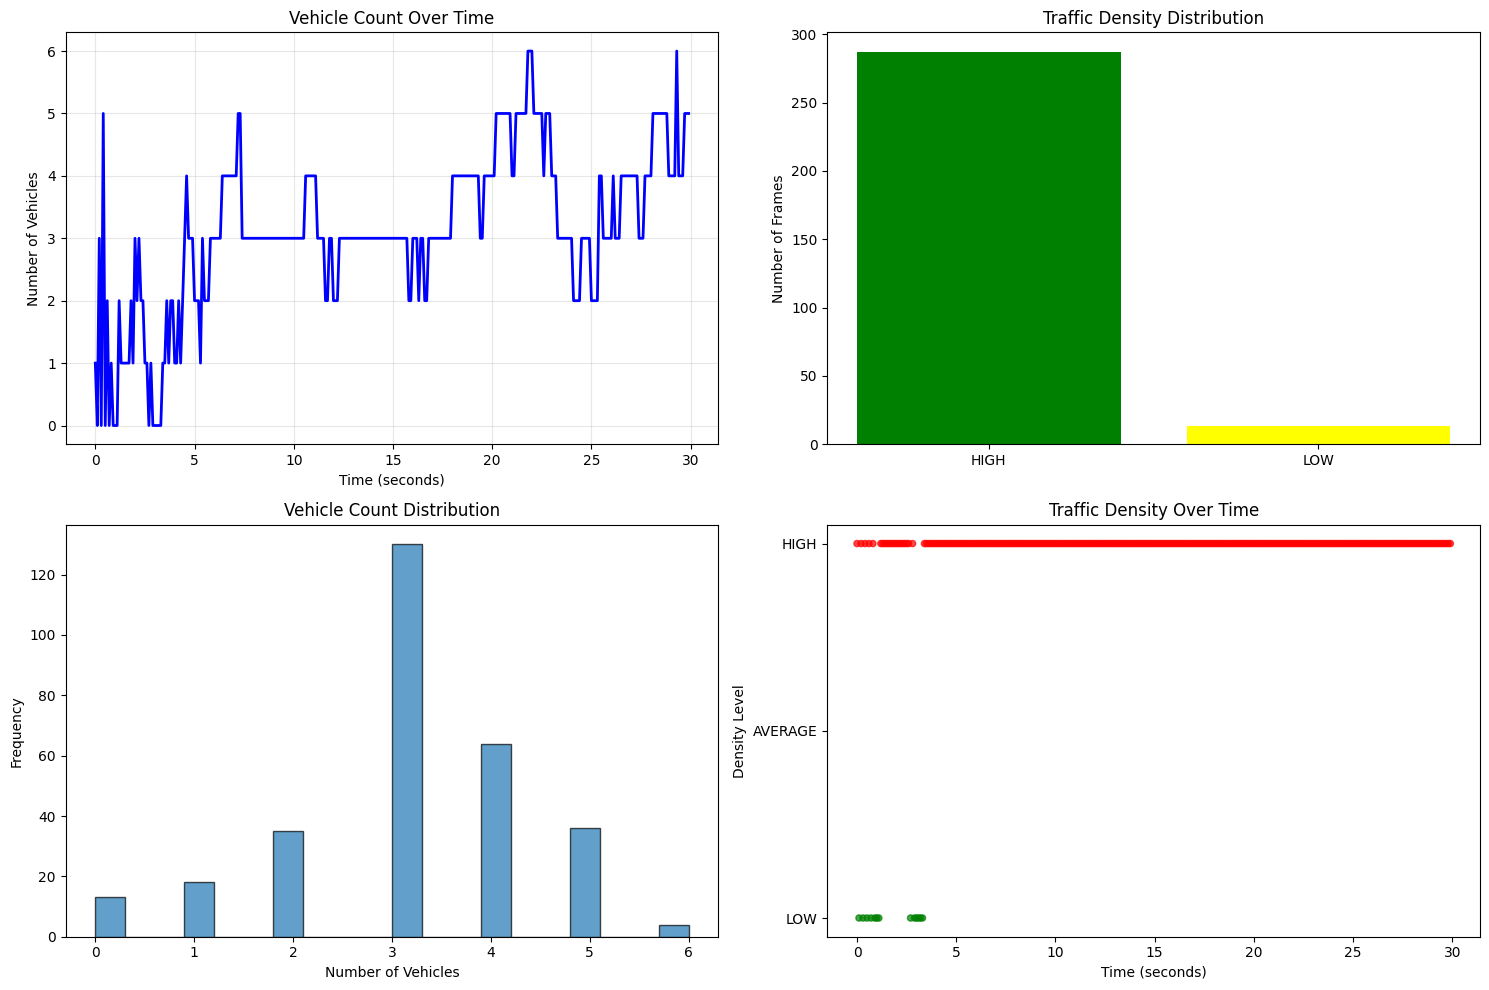


=== TRAFFIC ANALYSIS SUMMARY ===
Total frames processed: 300
Video duration: 30.0 seconds
Average vehicles per frame: 3.1
Maximum vehicles detected: 6
Minimum vehicles detected: 0

Density Distribution:
  HIGH: 287 frames (95.7%)
  LOW: 13 frames (4.3%)

Output Files Generated:
  1. traffic_example_analysis_full_analysis.mp4 (3.1 MB)
  2. traffic_example_analysis_detection_only.mp4 (2.8 MB)
  3. traffic_example_analysis_background_mask.mp4 (2.9 MB)


In [39]:
# Visualize results and analytics
if 'results' in locals() and results:
    vehicle_counts = results['vehicle_counts']
    density_levels = results['density_levels']
    
    # Create analytics plots
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Plot 1: Vehicle count over time
    time_axis = np.arange(len(vehicle_counts)) / 10.0  # Assuming 10 fps
    axes[0, 0].plot(time_axis, vehicle_counts, 'b-', linewidth=2)
    axes[0, 0].set_title('Vehicle Count Over Time')
    axes[0, 0].set_xlabel('Time (seconds)')
    axes[0, 0].set_ylabel('Number of Vehicles')
    axes[0, 0].grid(True, alpha=0.3)
    
    # Plot 2: Density distribution
    density_counts = {}
    for level in density_levels:
        density_counts[level] = density_counts.get(level, 0) + 1
    
    axes[0, 1].bar(density_counts.keys(), density_counts.values(), 
                   color=['green', 'yellow', 'red'][:len(density_counts)])
    axes[0, 1].set_title('Traffic Density Distribution')
    axes[0, 1].set_ylabel('Number of Frames')
    
    # Plot 3: Vehicle count histogram
    axes[1, 0].hist(vehicle_counts, bins=20, alpha=0.7, edgecolor='black')
    axes[1, 0].set_title('Vehicle Count Distribution')
    axes[1, 0].set_xlabel('Number of Vehicles')
    axes[1, 0].set_ylabel('Frequency')
    
    # Plot 4: Density over time
    density_numeric = []
    for level in density_levels:
        if level == 'LOW':
            density_numeric.append(0)
        elif level == 'AVERAGE':
            density_numeric.append(1)
        else:  # HIGH
            density_numeric.append(2)
    
    colors = ['green' if d == 0 else 'yellow' if d == 1 else 'red' for d in density_numeric]
    axes[1, 1].scatter(time_axis, density_numeric, c=colors, alpha=0.7, s=20)
    axes[1, 1].set_title('Traffic Density Over Time')
    axes[1, 1].set_xlabel('Time (seconds)')
    axes[1, 1].set_ylabel('Density Level')
    axes[1, 1].set_yticks([0, 1, 2])
    axes[1, 1].set_yticklabels(['LOW', 'AVERAGE', 'HIGH'])
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print(f"\n=== TRAFFIC ANALYSIS SUMMARY ===")
    print(f"Total frames processed: {len(vehicle_counts)}")
    print(f"Video duration: {len(vehicle_counts) / 10.0:.1f} seconds")
    print(f"Average vehicles per frame: {np.mean(vehicle_counts):.1f}")
    print(f"Maximum vehicles detected: {np.max(vehicle_counts)}")
    print(f"Minimum vehicles detected: {np.min(vehicle_counts)}")
    
    print(f"\nDensity Distribution:")
    total_frames = len(density_levels)
    for level, count in density_counts.items():
        percentage = (count / total_frames) * 100
        print(f"  {level}: {count} frames ({percentage:.1f}%)")
    
    print(f"\nOutput Files Generated:")
    for i, file_path in enumerate(results['output_files'], 1):
        file_size = Path(file_path).stat().st_size / (1024 * 1024)  # Size in MB
        print(f"  {i}. {Path(file_path).name} ({file_size:.1f} MB)")

else:
    print("No results to visualize. Please run the video processing cell first.")

In [40]:
# Display output videos inline
if 'results' in locals() and results:
    from IPython.display import Video, display, HTML
    
    output_files = results['output_files']
    
    print("Generated Videos:")
    
    for i, video_path in enumerate(output_files):
        if Path(video_path).exists():
            print(f"\n{i+1}. {Path(video_path).name}")
            
            # Display each video
            try:
                display(HTML(f"<h3>{Path(video_path).stem.replace('_', ' ').title()}</h3>"))
                display(Video(video_path, width=640, height=480))
            except Exception as e:
                print(f"Could not display video: {e}")
                print(f"Video saved at: {video_path}")
        else:
            print(f"Video file not found: {video_path}")

else:
    print("No videos to display. Please run the processing cells first.")

Generated Videos:

1. traffic_example_analysis_full_analysis.mp4



2. traffic_example_analysis_detection_only.mp4



3. traffic_example_analysis_background_mask.mp4
